In [1]:
# Segmentation algorithm that deals with anti-aliasing and is more efficient - V3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from numba import jit

from scipy import ndimage as ndi
from skimage.color import rgb2lab, lab2rgb
from skimage import io, img_as_float, exposure
from skimage.segmentation import mark_boundaries

In [2]:
def display_image(img, len = 10):
  '''Displays an image'''
  plt.figure(figsize=(len, len))
  plt.imshow(img, cmap='gray')

def mean_color_img(image, segmentation, num_segments):
  '''Calculate the mean color of each region of a segmentation'''
  new_image = np.zeros_like(image)
  for i in range(num_segments):
    new_image[segmentation == i] = np.mean(image[segmentation == i], axis=0)
  return new_image

def display_segment(segment_to_display, segmentation, len = 10):
  '''Display a given segment from a segmentation'''
  plt.figure(figsize=(len, len))
  plt.imshow(segmentation == segment_to_display, cmap='gray')

def num_pixels(segment_index):
  '''Count number of pixels in a segment'''
  return np.sum(segmentation == segment_index)

def display_segmentation(image, segmentation, len = 18):
  '''Displays an image side by side with a segmentation'''
  fig, axes = plt.subplots(1, 2, figsize=(len, len), sharex=True, sharey=True)
  ax = axes.ravel()
  ax[0].imshow(image)
  ax[0].set_title('Original Image')
  ax[0].axis('off')
  ax[1].imshow(mark_boundaries(image, segmentation))
  ax[1].set_title("Labeled")
  ax[1].axis('off')
  print(num_segments)

In [3]:
# Step 1 - Import image (PNG assumed), delete opacity info and scale down
def load_png(filename, downsample = False):
  '''Loads an image from a file'''
  image = io.imread(filename + ".png")
  image = image[:, :, :3] # Remove alpha channel
  if downsample:
    image = image[::2, ::2] # Can adjust scaling factor
  return img_as_float(image)

image = load_png("6")

In [4]:
# Edge mask - Return, optimize loop by taking away unnecessary math, rearranging loop structure - also, should incorporate canny filter in for more detection - RETURN
@jit(fastmath = True, nopython = True)
def sobel_edge(image, threshold = 10, a = 1, b = 2):
    '''Sobel edge detection (float image --> 0's and 1's)'''
    Kx = np.array([[a, 0, -a],
                   [b, 0, -b],
                   [a, 0, -a]])
    Ky = np.array([[ a,  b,  a],
                   [ 0,  0,  0],
                   [-a, -b, -a]])

    # Get image dimensions
    rows, cols, channels = image.shape
    G = np.zeros((rows, cols, channels), dtype=np.float32)

    Ix = np.zeros((rows, cols, channels), dtype=np.float32)
    Iy = np.zeros((rows, cols, channels), dtype=np.float32)

    for i in range(1, rows-1):
        for j in range(1, cols-1):
            for k in range(channels):
              region = image[i-1:i+2, j-1:j+2, k]
              Ix[i, j, k] = np.sum(Kx * region)
              Iy[i, j, k] = np.sum(Ky * region)

    for k in range(channels):
        G[:, :, k] = np.hypot(Ix[:, :, k], Iy[:, :, k])

    # Flatten, normalize to range 0 to 255
    H = np.sqrt(G[:, :, 0]**2 + G[:, :, 1]**2 + G[:, :, 2]**2)
    H = H / H.max() > threshold / 255

    return H

def enhance_contrast(image, percentile = 7):
  '''Enhance image contrast using contrast stretching - higher percentile, more stretching (float image --> float image)'''
  p2, p98 = np.percentile(image, (percentile, 100 - percentile))
  return exposure.rescale_intensity(image, in_range=(p2, p98))


edges = sobel_edge(enhance_contrast(image), 20).astype(int)

Text(0.5, 1.0, 'Edge Detection')

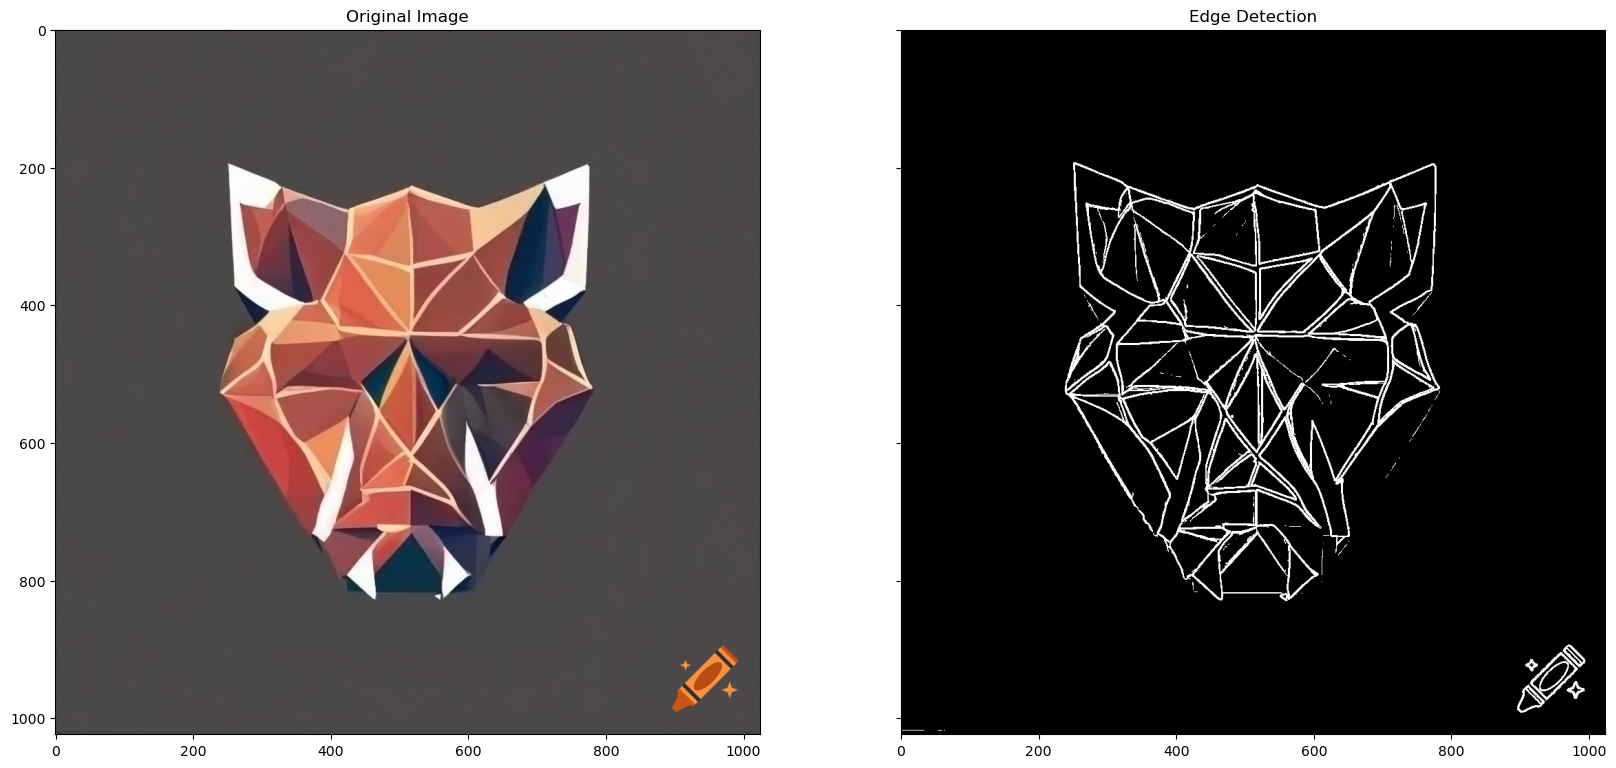

In [5]:
# Display images next to one another
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(20, 10))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[1].imshow(edges, cmap=plt.cm.gray)
axes[1].set_title('Edge Detection')

In [6]:
# Alg - Flood fill algorithm, S, i, j, c --> S -- improve with full stack and pointers

@jit(fastmath = True)
def color_distance(col1, col2):
  '''Get Euclidean distance squared between two lab colors'''
  return (col1[0] - col2[0]) ** 2 + (col1[1] - col2[1]) ** 2 + (col1[2] - col2[2]) ** 2

@jit(fastmath = True)
def floodFill(S, i, j, new_val, color_dist_thresh, lab_image):
  '''Flood-fill algorithm'''
  rows, cols = S.shape
  dx = [1, -1, 0, 0]
  dy = [0, 0, 1, -1]
  visited = np.zeros_like(S)
  stack = [(i, j)]
  visited[i, j] = 1
  target_val = S[i, j]
  sum_colors = np.copy(lab_image[i, j])
  num_pixels = 1

  while stack:
    # Pop the current entry, add it to the region, update color sum and pixel number
    cx, cy = stack.pop()
    S[cx, cy] = new_val
    sum_colors += lab_image[cx, cy]
    num_pixels += 1
    mean_color = sum_colors / num_pixels

    # Consider neighboring pixels
    for i in range(4):
      nx = cx + dx[i]
      ny = cy + dy[i]
      if nx < 0 or nx >= rows or ny < 0 or ny >= cols:
          continue
      if S[nx, ny] != target_val:
          continue
      if visited[nx, ny]:
          continue
      if color_distance(mean_color, lab_image[nx, ny]) > color_dist_thresh:
        continue
      visited[cx, cy] = 1
      stack.append((nx, ny))

In [7]:
# Alg - Segment the image using flood-fill
def floodSegment(lab_image, edges, color_thresh = 300):
  segmentation = - edges
  segmentation[segmentation == 0] = -2
  num_rows, num_columns = np.shape(edges)

  # Flood-fill with color thresholding to get segmentation
  c = 0
  for i in range(num_rows):
    for j in range(num_columns):
      if segmentation[i, j] == -2:
        floodFill(segmentation, i, j, c, color_thresh, lab_image)
        c += 1
      elif segmentation[i, j] == -1:
        segmentation[i, j] = -1
  return segmentation, c

In [8]:
# Alg - Classify small regions of the segmentation as -1 (could change this to add them to neighboring regions)
def cleanSegmentation(segmentation, num_segments, min_seg_pixels = 5):
  kept_segs = []
  for i in range(num_segments):
    if num_pixels(i) < min_seg_pixels:
      segmentation[segmentation == i] = -1
    else:
      kept_segs.append(i)
  num_segments = len(kept_segs)
  for i in range(num_segments):
    segmentation[segmentation == kept_segs[i]] = i
  return segmentation, num_segments

In [9]:
# Calculate the segmentation
segmentation, num_segments = floodSegment(rgb2lab(image), edges)
segmentation, num_segments = cleanSegmentation(segmentation, num_segments)

164


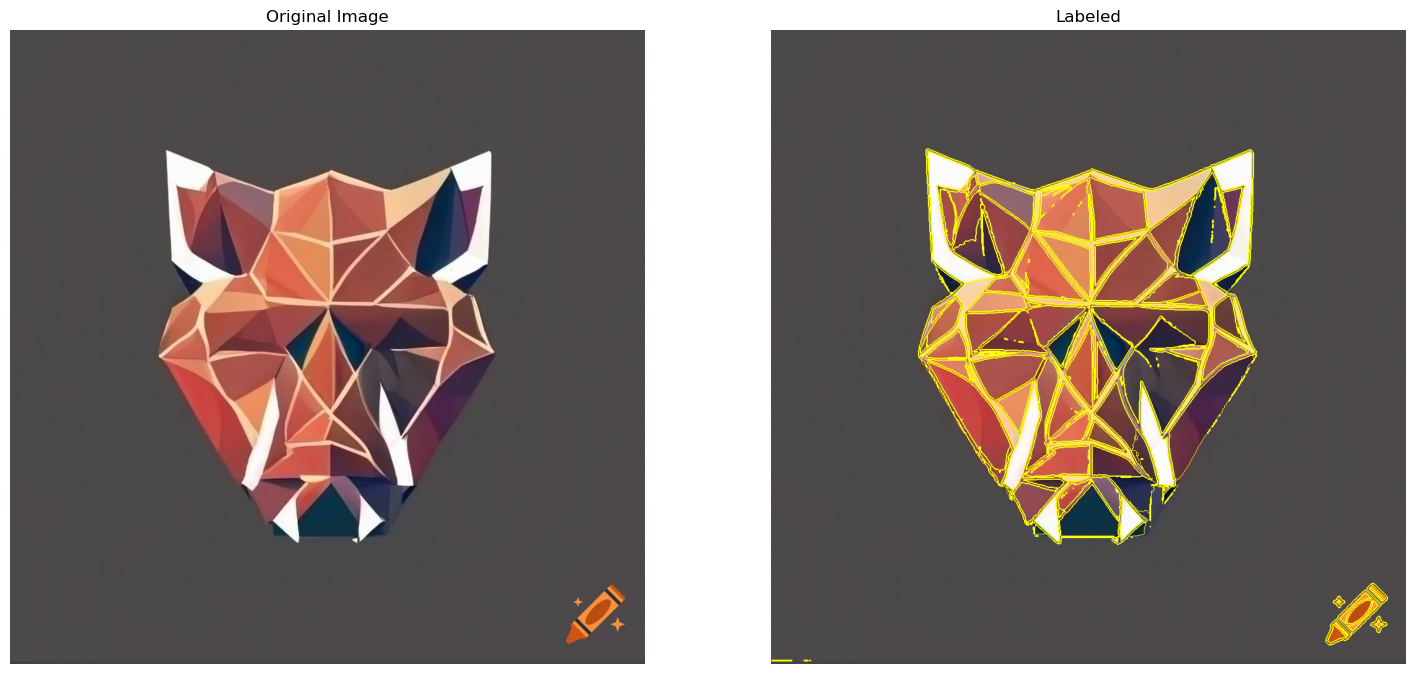

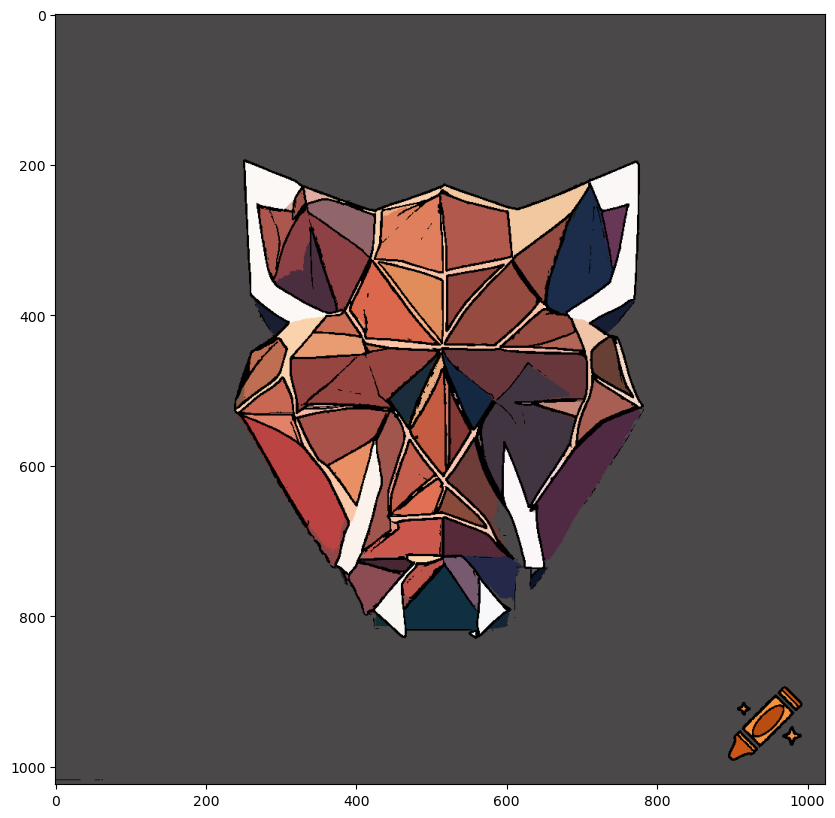

In [10]:
# Display segmentation
display_segmentation(image, segmentation)
display_image(mean_color_img(image, segmentation, num_segments))

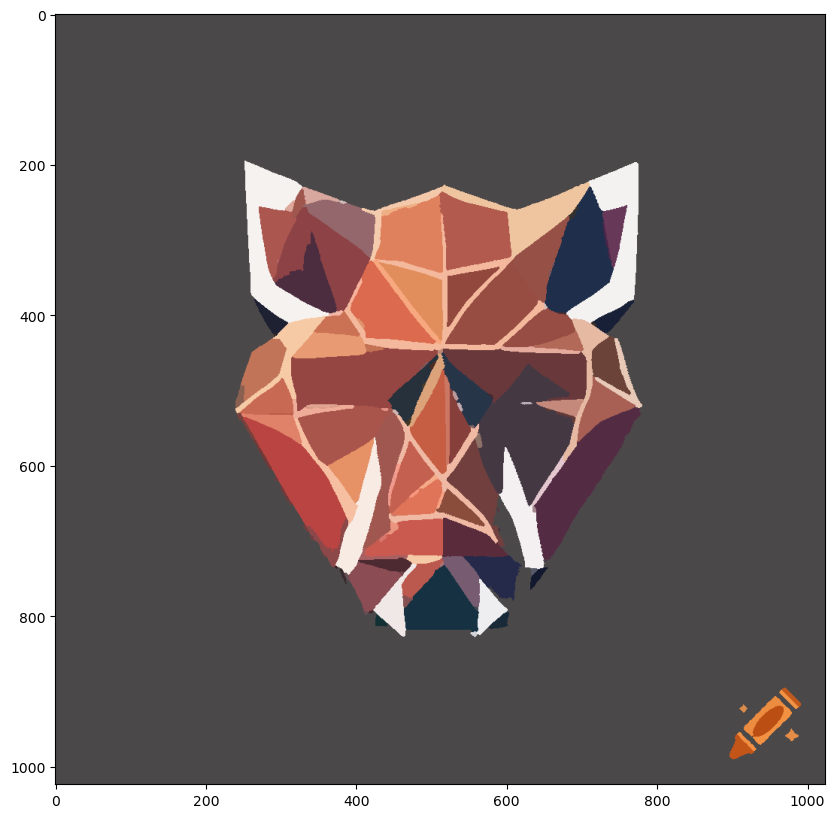

In [11]:
# Assign ambiguous/edge pixels to a neighboring segment

def initialize_degree(segmentation):
  degree = np.zeros_like(segmentation)
  degree[segmentation == -1] = -1
  return degree

def mean_cols(image, segmentation, num_segments):
  '''Calculate the mean color of each region of a segmentation'''
  mean_cols = np.zeros((num_segments, 3))
  for i in range(num_segments):
      mean_cols[i] = np.mean(image[segmentation == i], axis=0)
  return mean_cols

@jit(fastmath = True)
def nbr_regions(i, j, seg, rows, cols, degree):
  '''Get the neighboring regions of a given pixel, as well as the minimal degree of each region'''
  nbrs = np.full(4, -1)
  degs = np.full(4, -1)
  if i < rows - 1:
    nbrs[0] = (seg[i + 1, j])
    degs[0] = (degree[i + 1, j])
  if i > 0:
    nbrs[1] = (seg[i - 1, j])
    degs[1] = (degree[i - 1, j])
  if j < cols - 1:
    nbrs[2] = (seg[i, j + 1])
    degs[2] = (degree[i, j + 1])
  if j > 0:
    nbrs[3] = (seg[i, j - 1])
    degs[3] = (degree[i, j - 1])
  unique_nbrs = np.unique(nbrs[nbrs != -1])
  min_degrees = np.array([np.min(degs[nbrs == unique_nbrs[i]]) for i in range(len(unique_nbrs))])
  return unique_nbrs, min_degrees

def assign_px(lab_image, seg, degree, idx, nbrs, degs, stack, mean_colors, iter_num):
  '''Assign an edge pixel to a neighboring region or add it to a queue (defer)'''
  if len(nbrs) == 1 and (degs[0] == 0 or iter_num > 0):
    seg[idx] = nbrs[0]
    degree[idx] = degs[0] + 1
    return
  if len(nbrs) >= 2:
    if len(np.where(degs == np.min(degs))) == 1:
      seg[idx] = nbrs[np.argmin(degs)]
      degree[idx] = degs[np.argmin(degs)] + 1
    else:
      pix_col = lab_image[idx]
      dists = np.zeros(len(nbrs))
      for i in range(len(nbrs)):
        dists[i] = color_distance(pix_col, mean_colors[nbrs[i]])
      seg[idx] = nbrs[np.argmin(dists)]
      degree[idx] = degs[np.argmin(dists)] + 1
    return
  stack.append(idx)

def assign_edge_pixels(lab_image, mean_colors, degree, seg):
  '''Create new segmentation assigning edge pixels to closest neighboring region '''
  stack = []
  rows, cols = np.shape(seg)
  for idx in zip(*np.where(seg == -1)):
    nbrs, degs = nbr_regions(idx[0], idx[1], seg, rows, cols, degree)
    assign_px(lab_image, seg, degree, idx, nbrs, degs, stack, mean_colors, 0)
  while stack:
    idx = stack.pop()
    nbrs, degs = nbr_regions(idx[0], idx[1], seg, rows, cols, degree)
    assign_px(lab_image, seg, degree, idx, nbrs, degs, stack, mean_colors, 1)
  return seg

segmentation = assign_edge_pixels(rgb2lab(image), mean_cols(image, segmentation, num_segments), initialize_degree(segmentation), segmentation)
display_image(mean_color_img(image, segmentation, num_segments))

In [12]:
# Save array for testing
np.save("segmentation.npy", segmentation)

In [13]:
# Get array of mean RGB colors for each segment - kind of slow (0.6 sec), wtv, numba speed-up possible
segment_colors = np.zeros((num_segments, 3), dtype = int)
for i in range(num_segments):
    segment_colors[i, :] = np.round(np.mean(image[segmentation == i], axis=0) * 255)

# Save array for testing
np.save("segment_colors.npy", segment_colors)